In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv


# 1.  Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# 2. Loading up Dataset

In [3]:
df=pd.read_csv('/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv', delimiter=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Converting the range of the attribute **age** from days to years:

In [6]:
df['age']=df['age'].apply(lambda x: x/365).astype(int)

Converting the attribute **height** from centimeters to meters, for ease in **bmi** feature creation:

In [7]:
df['height']=df['height'].apply(lambda x: x/100)

In [8]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,1.68,62.0,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.0,140,90,3,1,0,0,1,1
2,2,51,1,1.65,64.0,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.0,150,100,1,1,0,0,1,1
4,4,47,1,1.56,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,1.68,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,1.58,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,1.83,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,1.63,72.0,135,80,1,2,0,0,0,1


In [9]:
df.nunique()

id             70000
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

#  3. Data Exploration

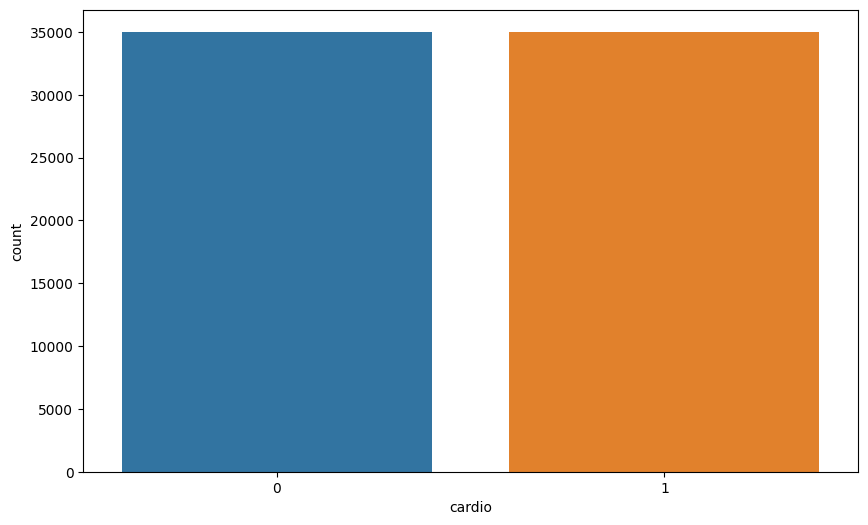

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='cardio')
plt.show()

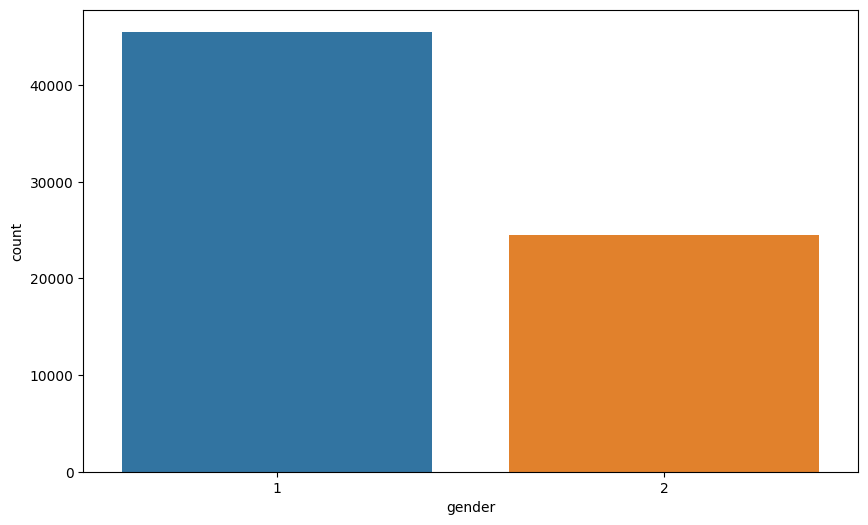

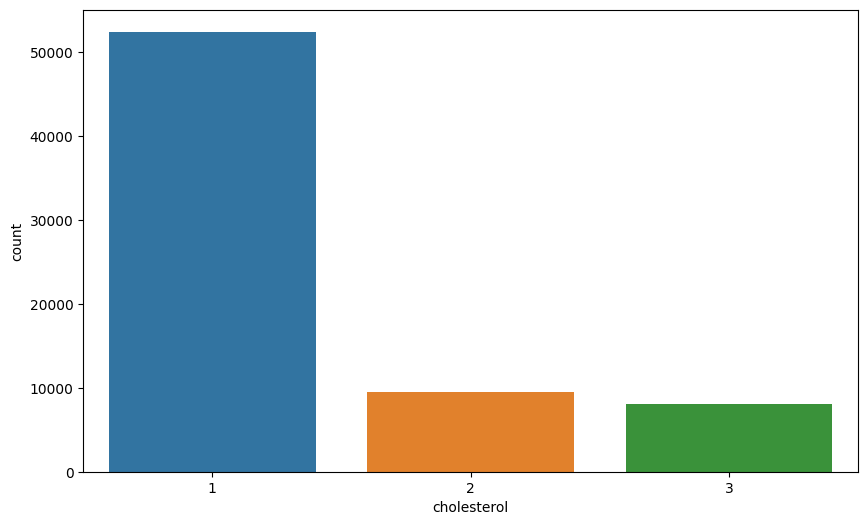

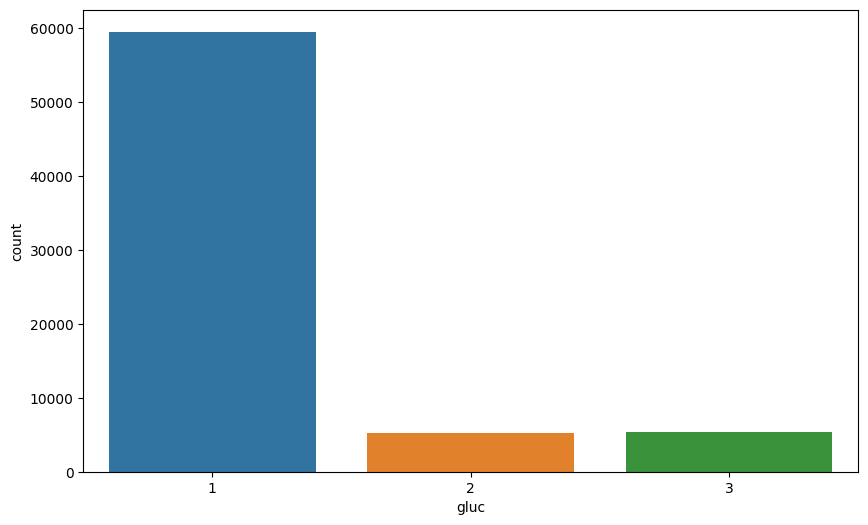

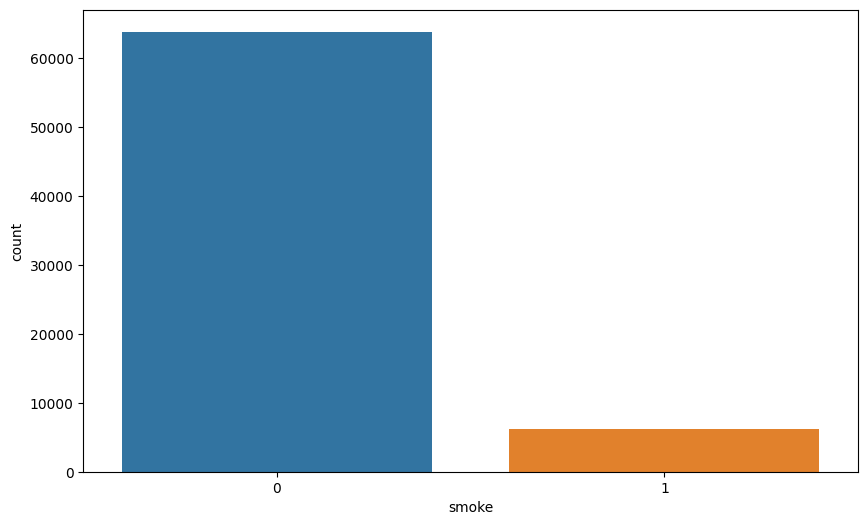

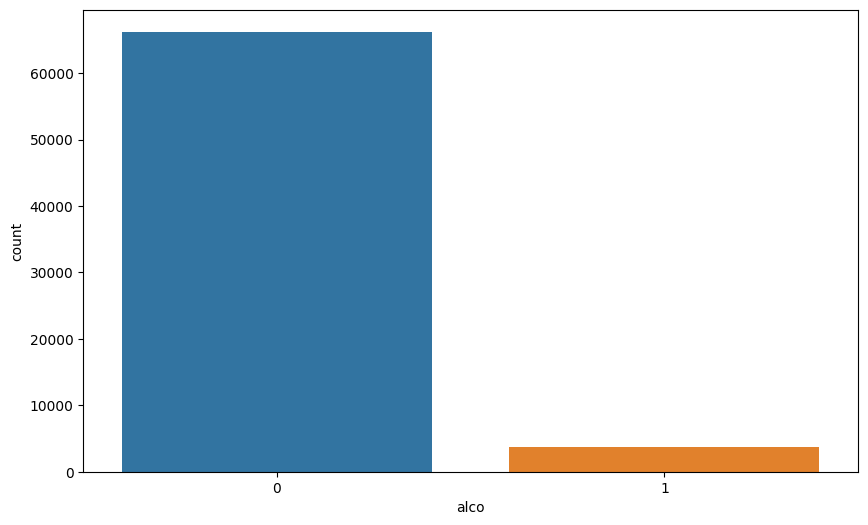

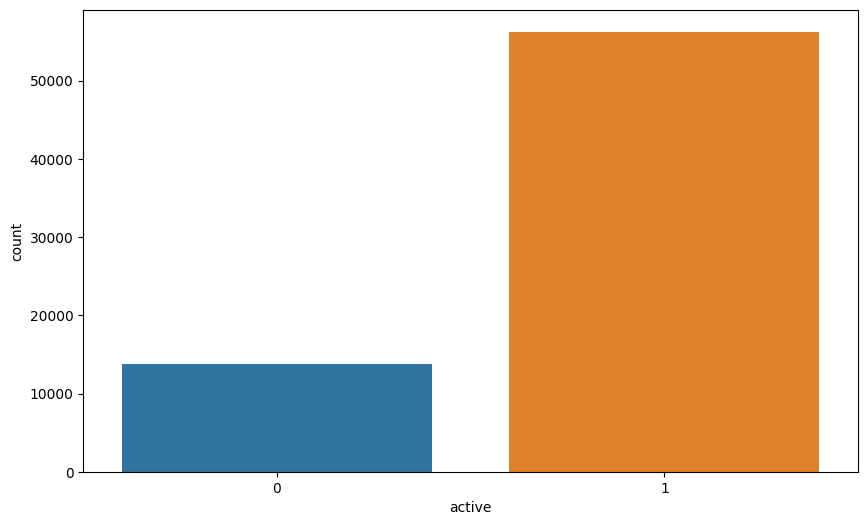

In [11]:
for i in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=i)
    plt.show()

**The columns 'smoke' and 'alco' are binary attributes, so converting them to categorical doesn't impact the dataset at all**

In [12]:
# df['smoke']=df['smoke'].apply(lambda x: 'y' if x==1 else 'n')
# df['alco']=df['alco'].apply(lambda x: 'y' if x==1 else 'n')

# 4. Creating New Features

With the existing attributes, we can create the following features:
* pulse_pressure: Calculated by taking difference of the dyastolic and systolic blood pressures.
* map: (Mean Arterial Pressure)
* bmi: (Body Mass Index)
* sys_dsys_ratio: Ratio between the systolic and dyastiloc blood pressure


In [13]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

df['map'] = df['ap_lo'] + (df['ap_hi'] - df['ap_lo'])/3

df['bmi']=df['weight']/(df['height'])**2

df['sys_dsys_ratio'] = df['ap_hi'] / df['ap_lo']


# 5. Converting Existing Attributes
Attributes like **cholesterol** and **gluc** have ordinal properties, so lets convert them to categorical:

In [14]:
df['cholesterol']=df['cholesterol'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))
df['gluc']=df['gluc'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))

In [15]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,pulse_pressure,map,bmi,sys_dsys_ratio
0,0,50,2,1.68,62.0,110,80,normal,normal,0,0,1,0,30,90.000000,21.967120,1.375000
1,1,55,1,1.56,85.0,140,90,well_above_normal,normal,0,0,1,1,50,106.666667,34.927679,1.555556
2,2,51,1,1.65,64.0,130,70,well_above_normal,normal,0,0,0,1,60,90.000000,23.507805,1.857143
3,3,48,2,1.69,82.0,150,100,normal,normal,0,0,1,1,50,116.666667,28.710479,1.500000
4,4,47,1,1.56,56.0,100,60,normal,normal,0,0,0,0,40,73.333333,23.011177,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,1.68,76.0,120,80,normal,normal,1,0,1,0,40,93.333333,26.927438,1.500000
69996,99995,61,1,1.58,126.0,140,90,above_normal,above_normal,0,0,1,1,50,106.666667,50.472681,1.555556
69997,99996,52,2,1.83,105.0,180,90,well_above_normal,normal,0,1,0,1,90,120.000000,31.353579,2.000000
69998,99998,61,1,1.63,72.0,135,80,normal,above_normal,0,0,0,1,55,98.333333,27.099251,1.687500


In [16]:
num_cols=df.select_dtypes(exclude='object').columns
cat_cols=df.select_dtypes(include='object').columns

# 6. Feature Analysis (EDA)

<Axes: ylabel='count'>

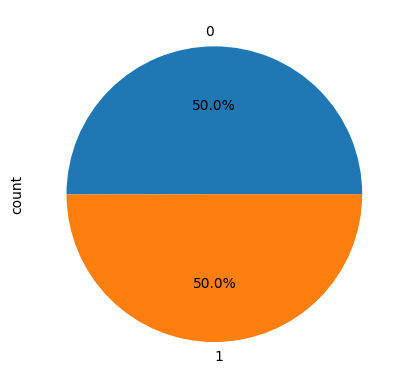

In [17]:
df['cardio'].value_counts().plot.pie(autopct='%1.1f%%')

# 6. Categorical Analysis

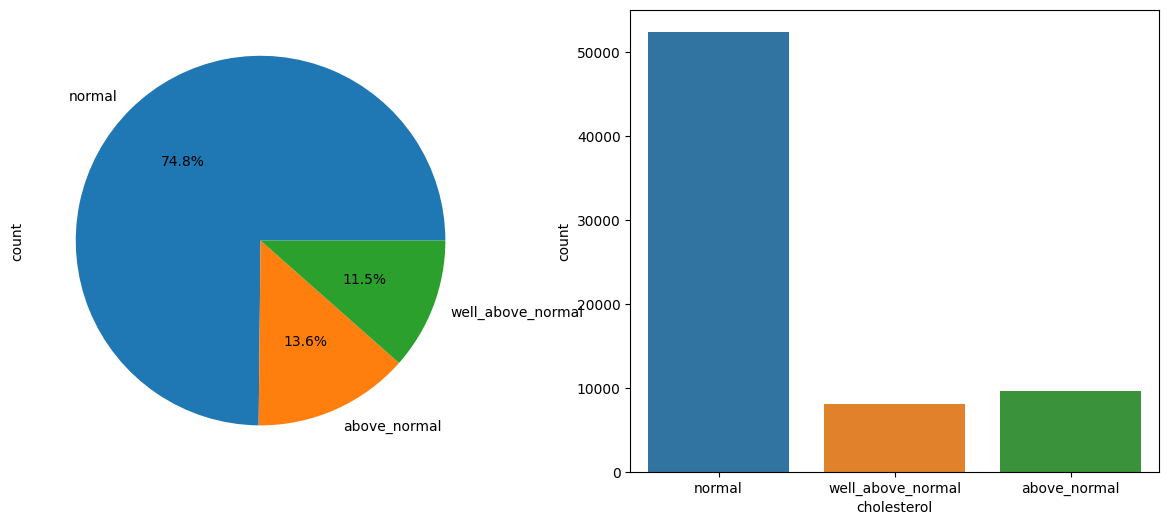

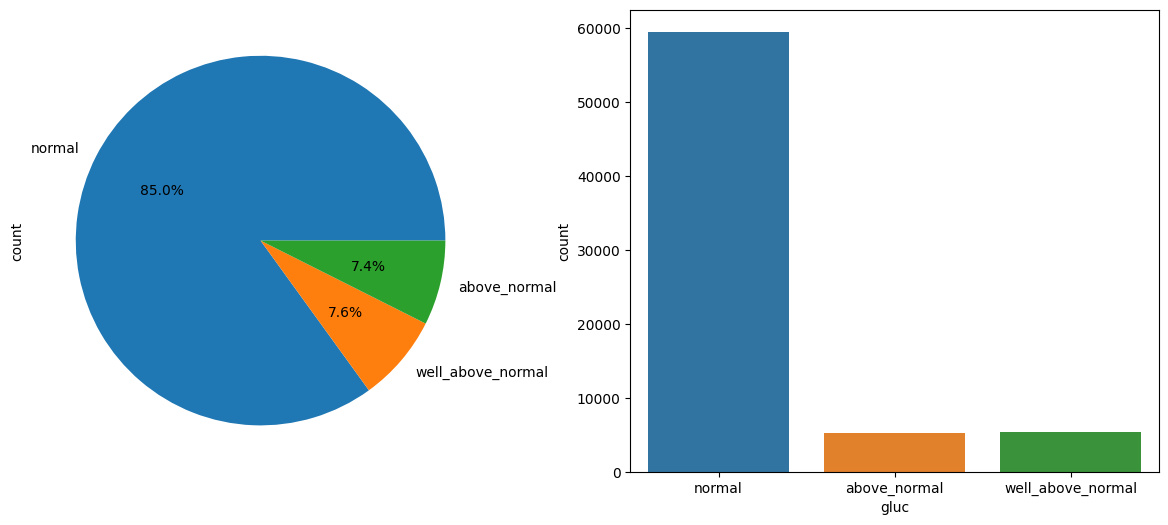

In [18]:
for i in cat_cols:
    f, ax=plt.subplots(1, 2, figsize=(15,6))
    df[i].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
    sns.countplot(data=df, x=i, ax=ax[1])

# 7. NUMERIC ANALYSIS

In [19]:
df[num_cols]

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,pulse_pressure,map,bmi,sys_dsys_ratio
0,0,50,2,1.68,62.0,110,80,0,0,1,0,30,90.000000,21.967120,1.375000
1,1,55,1,1.56,85.0,140,90,0,0,1,1,50,106.666667,34.927679,1.555556
2,2,51,1,1.65,64.0,130,70,0,0,0,1,60,90.000000,23.507805,1.857143
3,3,48,2,1.69,82.0,150,100,0,0,1,1,50,116.666667,28.710479,1.500000
4,4,47,1,1.56,56.0,100,60,0,0,0,0,40,73.333333,23.011177,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,1.68,76.0,120,80,1,0,1,0,40,93.333333,26.927438,1.500000
69996,99995,61,1,1.58,126.0,140,90,0,0,1,1,50,106.666667,50.472681,1.555556
69997,99996,52,2,1.83,105.0,180,90,0,1,0,1,90,120.000000,31.353579,2.000000
69998,99998,61,1,1.63,72.0,135,80,0,0,0,1,55,98.333333,27.099251,1.687500


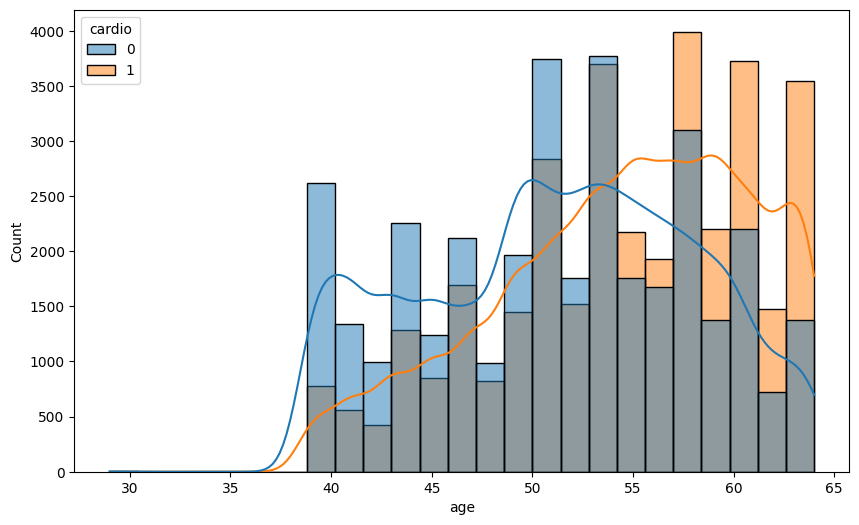

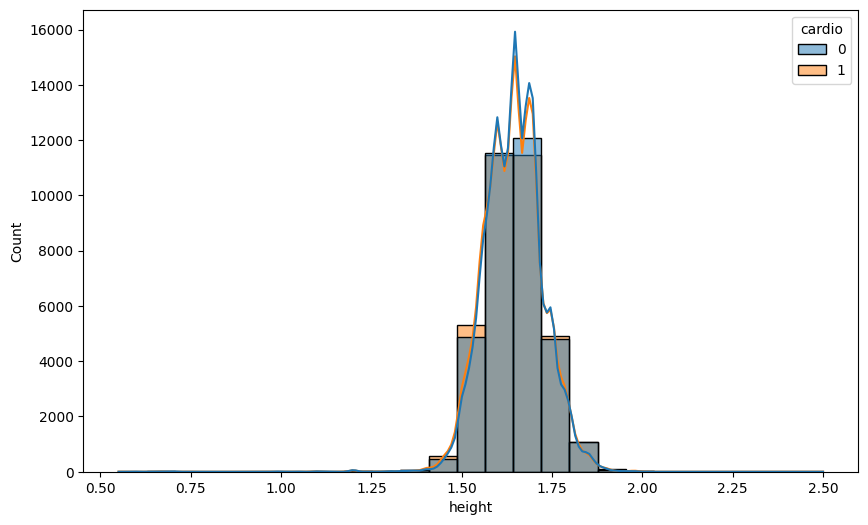

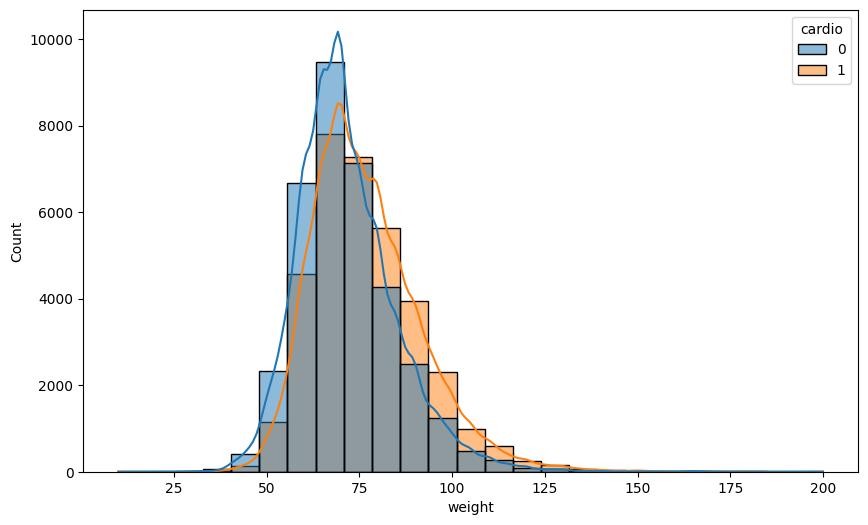

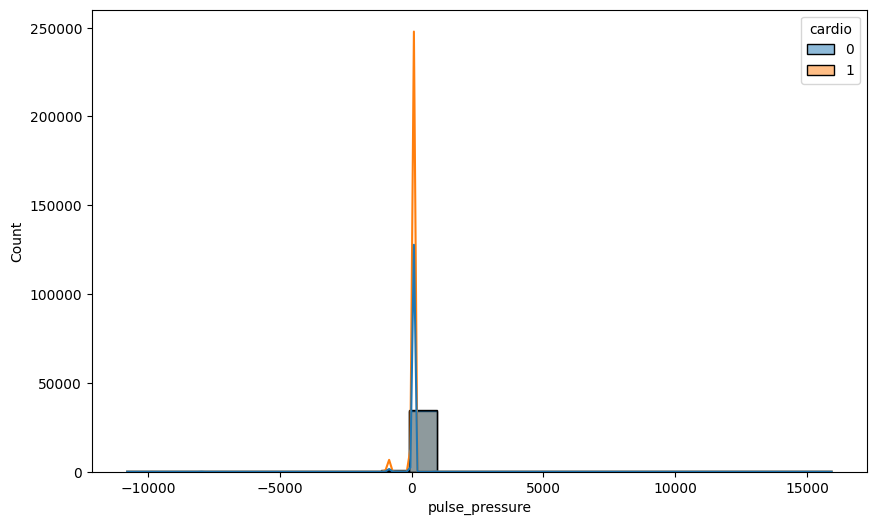

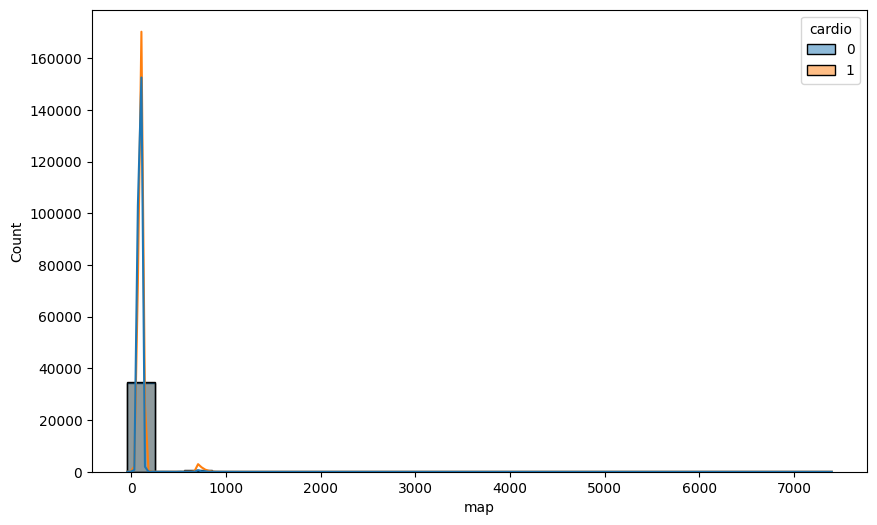

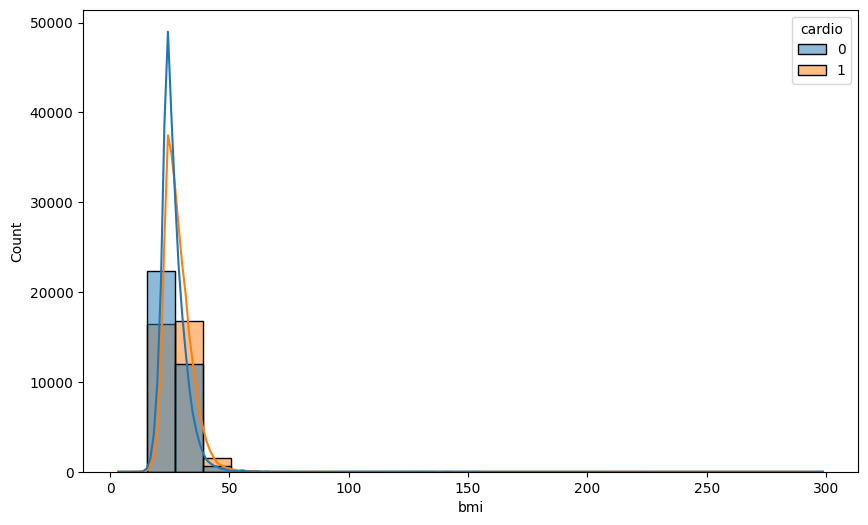

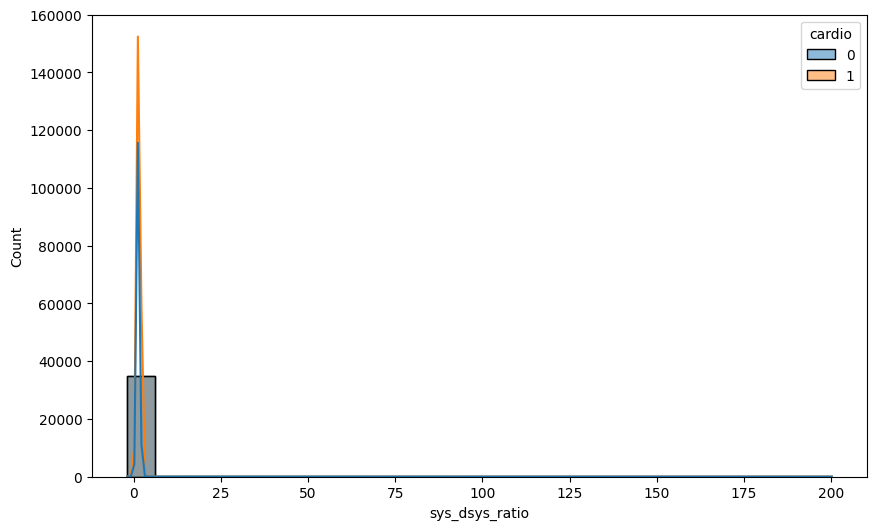

In [20]:
for i in num_cols.drop(['id', 'gender', 'ap_hi', 'ap_lo', 'smoke','alco','active','cardio']):
    plt.figure(figsize=(10,6))
    sns.histplot(data=df, x=i, hue='cardio', bins=25, kde=True)
    plt.show()

# 8. Attribute Normalzation

In [21]:
from scipy.stats import boxcox

In [22]:
age=np.array(df['age'])
_, opt_lambda=boxcox(age)
print(opt_lambda)

2.0359776050549496


In [23]:
df['age_box']=boxcox(df['age'], lmbda=opt_lambda)

In [24]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio',
       'pulse_pressure', 'map', 'bmi', 'sys_dsys_ratio', 'age_box'],
      dtype='object')

In [25]:
# df['bmi_log']=np.log(df['bmi']+1)
# df['map_log']=np.log(df['map']+1)
# df['pp_log']=np.log(df['pulse_pressure']+1)
# df['weight_log']=np.log(df['weight']+1)

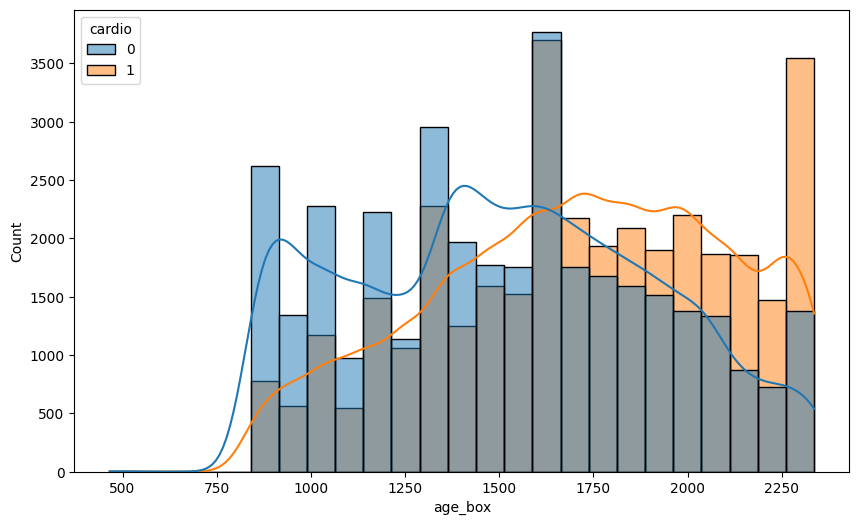

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='age_box', hue='cardio', bins=25, kde=True)
plt.show()

we have much better distribution of the age attribute now

# 9. MULTIVARIATE ANALYSIS


In [27]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio',
       'pulse_pressure', 'map', 'bmi', 'sys_dsys_ratio', 'age_box'],
      dtype='object')

<Figure size 1000x1000 with 0 Axes>

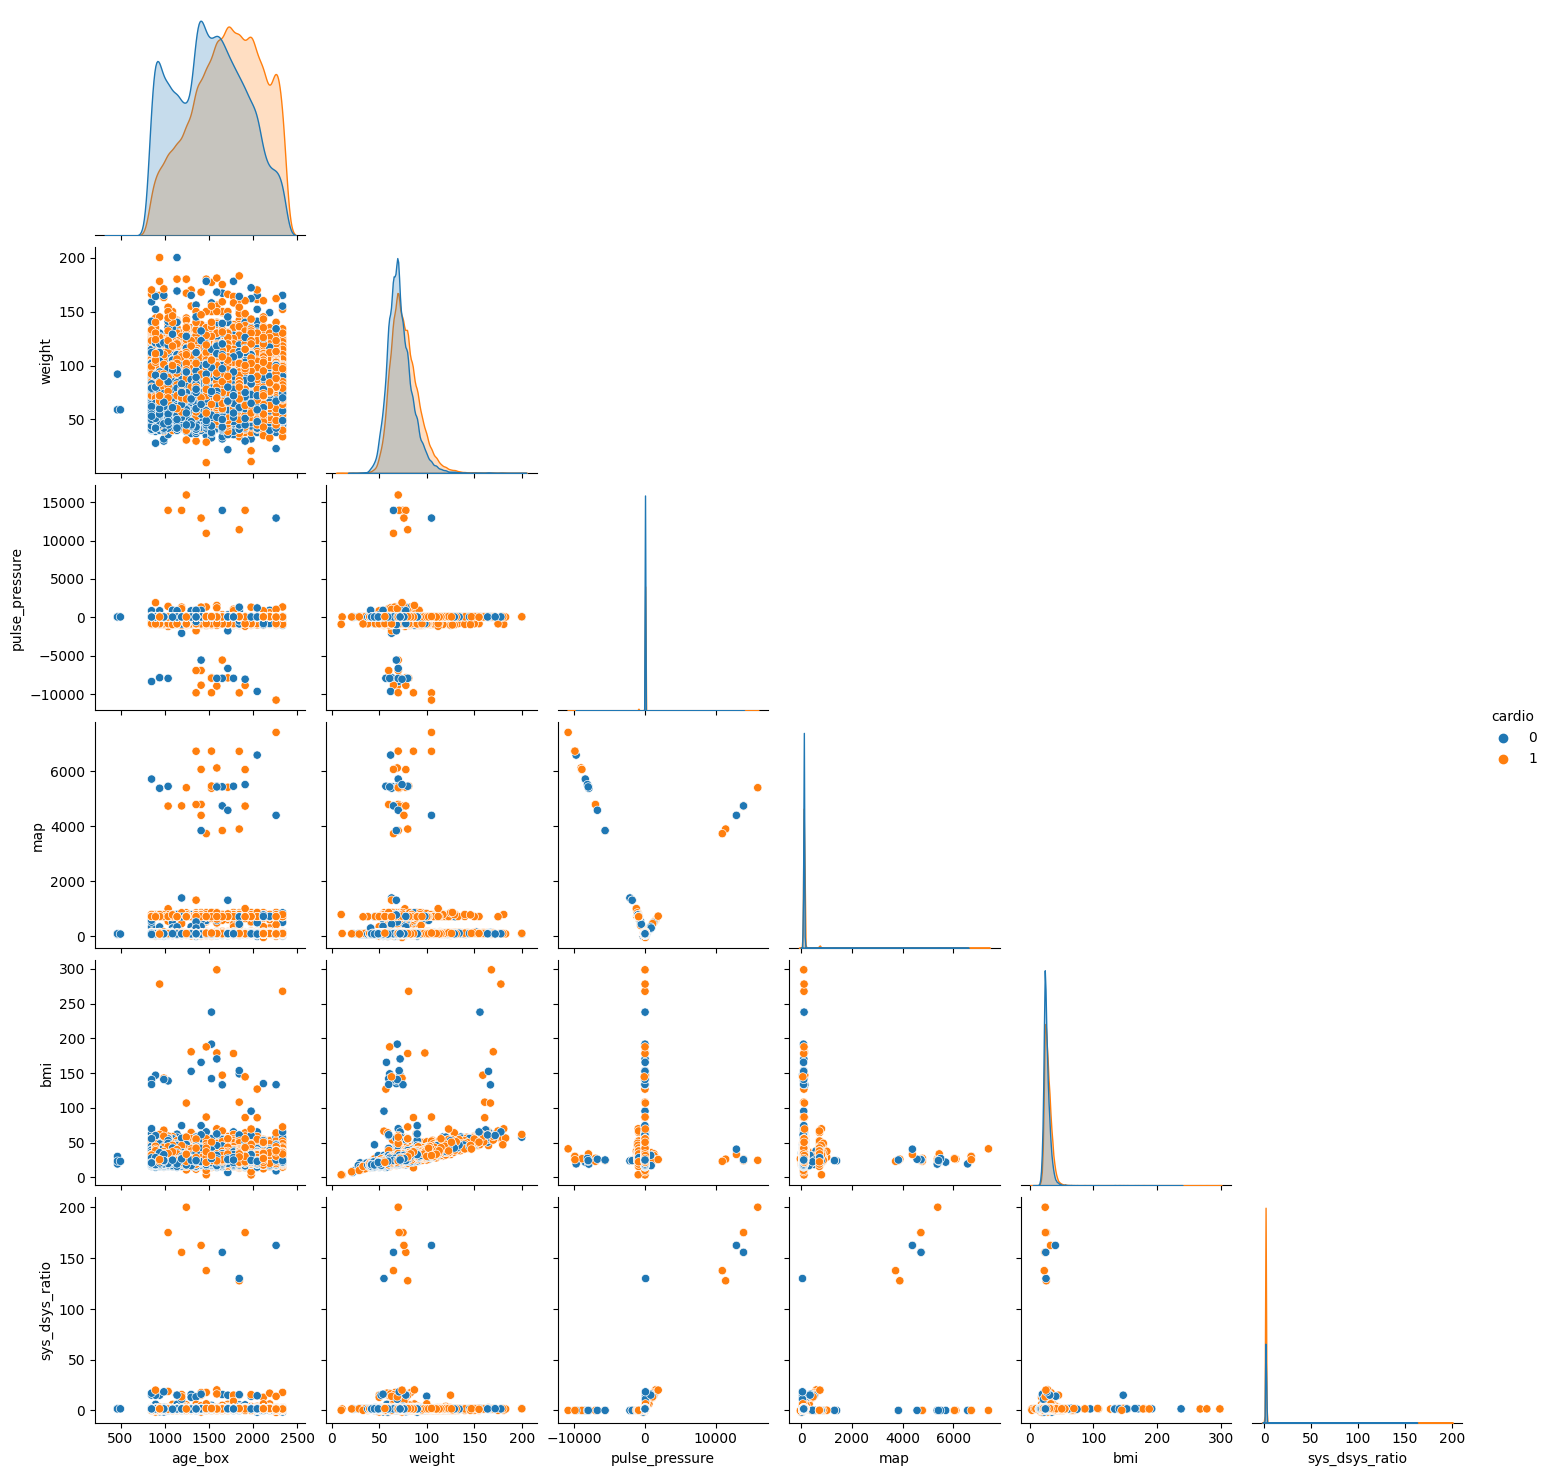

In [28]:
cols=df[['age_box', 'weight', 'pulse_pressure', 'map','bmi', 'sys_dsys_ratio', 'cardio']]
plt.figure(figsize=(10,10))
sns.pairplot(cols, hue='cardio', corner=True)
plt.show()

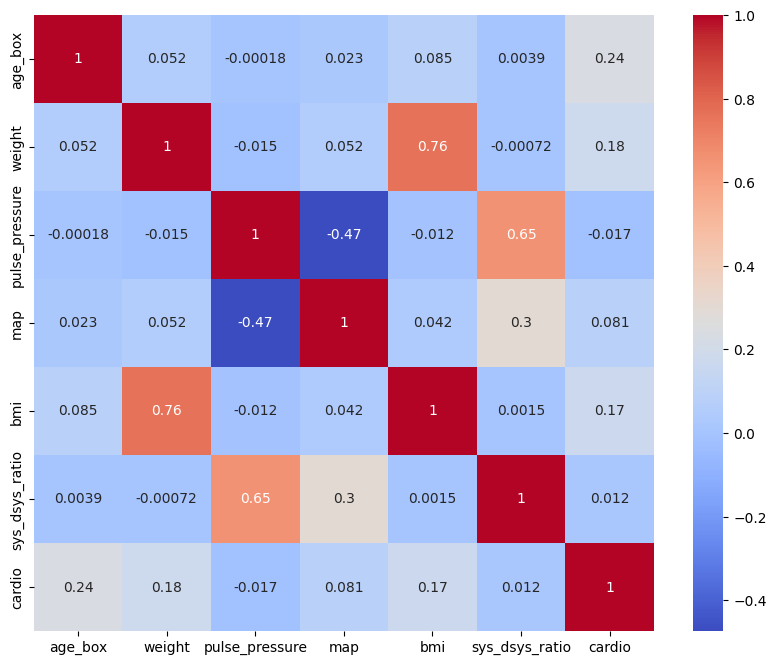

In [29]:
corr=cols.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

# 10. Feature Selection/ Engineering

In [30]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio',
       'pulse_pressure', 'map', 'bmi', 'sys_dsys_ratio', 'age_box'],
      dtype='object')

In [31]:
features=df[['age_box','weight', 'cholesterol', 'gluc', 'smoke', 'alco','pulse_pressure', 'map', 'bmi']]
target=df['cardio']

In [32]:
num_features=features.select_dtypes(exclude='object').columns
cat_features=features.select_dtypes(include='object').columns

In [33]:
num_features

Index(['age_box', 'weight', 'smoke', 'alco', 'pulse_pressure', 'map', 'bmi'], dtype='object')

In [34]:
cat_features

Index(['cholesterol', 'gluc'], dtype='object')

In [35]:
features

,age_box,weight,cholesterol,gluc,smoke,alco,pulse_pressure,map,bmi
0,1412.996048,62.0,normal,normal,0,0,30,90.000000,21.967120
1,1715.703170,85.0,well_above_normal,normal,0,0,50,106.666667,34.927679
2,1471.149030,64.0,well_above_normal,normal,0,0,60,90.000000,23.507805
3,1300.266853,82.0,normal,normal,0,0,50,116.666667,28.710479
4,1245.688889,56.0,normal,normal,0,0,40,73.333333,23.011177
...,...,...,...,...,...,...,...,...,...
69995,1530.495406,76.0,normal,normal,1,0,40,93.333333,26.927438
69996,2118.448375,126.0,above_normal,above_normal,0,0,50,106.666667,50.472681
69997,1530.495406,105.0,well_above_normal,normal,0,1,90,120.000000,31.353579
69998,2118.448375,72.0,normal,above_normal,0,0,55,98.333333,27.099251


In [36]:
target

0        0
1        1
2        1
3        1
4        0
        ..
69995    0
69996    1
69997    1
69998    1
69999    0
Name: cardio, Length: 70000, dtype: int64

# 11. Scaling Numerical Features

In [37]:
scaler=StandardScaler()

In [38]:
features[num_features]=scaler.fit_transform(features[num_features])

In [39]:
features

,age_box,weight,cholesterol,gluc,smoke,alco,pulse_pressure,map,bmi
0,-0.482921,-0.847873,normal,normal,-0.310879,-0.238384,-0.009057,-0.127182,-0.917577
1,0.264228,0.749831,well_above_normal,normal,-0.310879,-0.238384,0.073770,-0.005075,1.210081
2,-0.339386,-0.708942,well_above_normal,normal,-0.310879,-0.238384,0.115184,-0.127182,-0.664652
3,-0.761162,0.541435,normal,normal,-0.310879,-0.238384,0.073770,0.068189,0.189440
4,-0.895872,-1.264666,normal,normal,-0.310879,-0.238384,0.032357,-0.249288,-0.746181
...,...,...,...,...,...,...,...,...,...
69995,-0.192906,0.124642,normal,normal,3.216684,-0.238384,0.032357,-0.102760,-0.103271
69996,1.258294,3.597913,above_normal,above_normal,-0.310879,-0.238384,0.073770,-0.005075,3.762011
69997,-0.192906,2.139139,well_above_normal,normal,-0.310879,4.194906,0.239424,0.092610,0.623342
69998,1.258294,-0.153219,normal,above_normal,-0.310879,-0.238384,0.094477,-0.066128,-0.075066


# 12. Encoding Categorical Features

In [40]:
features=pd.get_dummies(features, columns=['cholesterol', 'gluc'])


In [41]:
features

,age_box,weight,smoke,alco,pulse_pressure,map,bmi,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal
0,-0.482921,-0.847873,-0.310879,-0.238384,-0.009057,-0.127182,-0.917577,False,True,False,False,True,False
1,0.264228,0.749831,-0.310879,-0.238384,0.073770,-0.005075,1.210081,False,False,True,False,True,False
2,-0.339386,-0.708942,-0.310879,-0.238384,0.115184,-0.127182,-0.664652,False,False,True,False,True,False
3,-0.761162,0.541435,-0.310879,-0.238384,0.073770,0.068189,0.189440,False,True,False,False,True,False
4,-0.895872,-1.264666,-0.310879,-0.238384,0.032357,-0.249288,-0.746181,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.192906,0.124642,3.216684,-0.238384,0.032357,-0.102760,-0.103271,False,True,False,False,True,False
69996,1.258294,3.597913,-0.310879,-0.238384,0.073770,-0.005075,3.762011,True,False,False,True,False,False
69997,-0.192906,2.139139,-0.310879,4.194906,0.239424,0.092610,0.623342,False,False,True,False,True,False
69998,1.258294,-0.153219,-0.310879,-0.238384,0.094477,-0.066128,-0.075066,False,True,False,True,False,False


# 13. MODELING

In [42]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=.30)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
lr=LogisticRegression()
kn=KNeighborsClassifier()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42 
)

In [45]:
lr.fit(x_train, y_train)
kn.fit(x_train, y_train)
dt.fit(x_train, y_train)
rf.fit(x_train, y_train)

lr_pred=lr.predict(x_test)
kn_pred=kn.predict(x_test)
dt_pred=dt.predict(x_test)
rf_pred=rf.predict(x_test)

In [46]:
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_confusion = confusion_matrix(y_test, lr_pred)
lr_classification_report_str = classification_report(y_test, lr_pred)

kn_accuracy=accuracy_score(y_test, kn_pred)
kn_confusion=confusion_matrix(y_test, kn_pred)
kn_classification_report_str=classification_report(y_test, kn_pred)

dt_accuracy=accuracy_score(y_test, dt_pred)
dt_confusion=confusion_matrix(y_test, dt_pred)
dt_classification_report_str=classification_report(y_test, dt_pred)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_confusion = confusion_matrix(y_test, rf_pred)
rf_classification_report_str = classification_report(y_test, rf_pred)

In [47]:
print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy}")
print("Confusion Matrix:")
print(lr_confusion)
print("Classification Report:")
print(lr_classification_report_str)

print('KNNClassifier Results: ')
print(f"Accuracy: {kn_accuracy}")
print("Confusion Matrix:")
print(kn_confusion)
print("Classification Report:")
print(kn_classification_report_str)

print('DTClassifier Results: ')
print(f"Accuracy: {dt_accuracy}")
print("Confusion Matrix:")
print(dt_confusion)
print("Classification Report:")
print(dt_classification_report_str)


print('Random Forest Classifier Results: ')
print(f"Accuracy: {dt_accuracy}")
print("Confusion Matrix:")
print(dt_confusion)
print("Classification Report:")
print(dt_classification_report_str)

Logistic Regression Results:
Accuracy: 0.7200952380952381
Confusion Matrix:
[[7985 2476]
 [3402 7137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73     10461
           1       0.74      0.68      0.71     10539

    accuracy                           0.72     21000
   macro avg       0.72      0.72      0.72     21000
weighted avg       0.72      0.72      0.72     21000

KNNClassifier Results: 
Accuracy: 0.6588095238095238
Confusion Matrix:
[[7133 3328]
 [3837 6702]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67     10461
           1       0.67      0.64      0.65     10539

    accuracy                           0.66     21000
   macro avg       0.66      0.66      0.66     21000
weighted avg       0.66      0.66      0.66     21000

DTClassifier Results: 
Accuracy: 0.6382857142857142
Confusion Matrix:
[[6860 3601]
 [3995 6544]]
Cl

Logistic Regression provides thet best accuracy **72%** out of the box, for predictions. Also it provides the best recall value **76%**

# 14 Cross Validation

In [48]:
models={
    'Logistic Regression':LogisticRegression(),
    'KNeighbor Classifier':KNeighborsClassifier(),
    'Decision Tree Classifier':DecisionTreeClassifier(),
    'Random Forest Classifier':RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42 
)
}

In [49]:
for i, mod in models.items():
    cv_scores = cross_val_score(mod, x_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores for {i}:, {cv_scores}") 
    print(f"Mean cross-validation score for {i}:, {cv_scores.mean()}")

Cross-validation scores for Logistic Regression:, [0.71071429 0.71908163 0.7177551  0.71408163 0.71255102]
Mean cross-validation score for Logistic Regression:, 0.7148367346938775
Cross-validation scores for KNeighbor Classifier:, [0.65255102 0.65173469 0.65693878 0.65479592 0.65193878]
Mean cross-validation score for KNeighbor Classifier:, 0.6535918367346938
Cross-validation scores for Decision Tree Classifier:, [0.64193878 0.63887755 0.64285714 0.63857143 0.64234694]
Mean cross-validation score for Decision Tree Classifier:, 0.6409183673469389
Cross-validation scores for Random Forest Classifier:, [0.70765306 0.70214286 0.70704082 0.7027551  0.70673469]
Mean cross-validation score for Random Forest Classifier:, 0.705265306122449


**Logistic Regression**
Accuracy: **72.01%**

Confusion Matrix:
True Negatives: 7985
False Positives: 2476
False Negatives: 3402
True Positives: 7137

Classification Report:
Precision: 0.70 (class 0), 0.74 (class 1)
Recall: 0.76 (class 0), 0.68 (class 1)
F1-Score: 0.73 (class 0), 0.71 (class 1)

Cross-Validation Mean Accuracy: **71.48%**

**K-Nearest Neighbors (KNN) Classifier**
Accuracy: **65.88%**

Confusion Matrix:
True Negatives: 7133
False Positives: 3328
False Negatives: 3837
True Positives: 6702

Classification Report:
Precision: 0.65 (class 0), 0.67 (class 1)
Recall: 0.68 (class 0), 0.64 (class 1)
F1-Score: 0.67 (class 0), 0.65 (class 1)

Cross-Validation Mean Accuracy: **65.36%**

**Decision Tree Classifier**
Accuracy: **63.88%**

Confusion Matrix:
True Negatives: 6863
False Positives: 3598
False Negatives: 3988
True Positives: 6551

Classification Report:
Precision: 0.63 (class 0), 0.65 (class 1)
Recall: 0.66 (class 0), 0.62 (class 1)
F1-Score: 0.64 (class 0), 0.63 (class 1)

Cross-Validation Mean Accuracy: **63.91%**

**Random Forest Classifier**
Accuracy: **63.88%**

Confusion Matrix:
True Negatives: 6863
False Positives: 3598
False Negatives: 3988
True Positives: 6551

Classification Report:
Precision: 0.63 (class 0), 0.65 (class 1)
Recall: 0.66 (class 0), 0.62 (class 1)
F1-Score: 0.64 (class 0), 0.63 (class 1)

Cross-Validation Mean Accuracy: **70.53%**

# 15. Boosting Algorithms

I have already chosen the best parameters for this classifier using **GridSearchCV**

In [50]:
model=XGBClassifier(objective='binary:logistic',learning_rate=0.1, max_depth=5, n_estimators=50, seed=42)

In [51]:
model.fit(x_train, y_train, verbose=True, early_stopping_rounds=5, eval_metric='auc', eval_set=[(x_test, y_test)])

[0]	validation_0-auc:0.79034
[1]	validation_0-auc:0.79272
[2]	validation_0-auc:0.79357
[3]	validation_0-auc:0.79477
[4]	validation_0-auc:0.79528
[5]	validation_0-auc:0.79649
[6]	validation_0-auc:0.79763
[7]	validation_0-auc:0.79780
[8]	validation_0-auc:0.79825
[9]	validation_0-auc:0.79854
[10]	validation_0-auc:0.79894
[11]	validation_0-auc:0.79920
[12]	validation_0-auc:0.79939
[13]	validation_0-auc:0.79973
[14]	validation_0-auc:0.79992
[15]	validation_0-auc:0.80027
[16]	validation_0-auc:0.80068
[17]	validation_0-auc:0.80077
[18]	validation_0-auc:0.80099
[19]	validation_0-auc:0.80126
[20]	validation_0-auc:0.80149
[21]	validation_0-auc:0.80151
[22]	validation_0-auc:0.80157
[23]	validation_0-auc:0.80181
[24]	validation_0-auc:0.80200
[25]	validation_0-auc:0.80222
[26]	validation_0-auc:0.80229
[27]	validation_0-auc:0.80250
[28]	validation_0-auc:0.80245
[29]	validation_0-auc:0.80264
[30]	validation_0-auc:0.80275
[31]	validation_0-auc:0.80276
[32]	validation_0-auc:0.80288
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
predictions=model.predict(x_test)

In [53]:
print('Accuracy Score: ', accuracy_score(y_test, predictions))

Accuracy Score:  0.737904761904762


In [54]:
l_model = LGBMClassifier(boosting_type='gbdt',
                         objective='binary',
                         learning_rate=0.1,
                         num_leaves=31,
                         max_depth=-1,
                         n_estimators=100,
                         subsample=1.0,
                         colsample_bytree=1.0,
                         reg_alpha=0.0,
                         reg_lambda=0.0,
                         random_state=42)

In [55]:
l_model.fit(x_train, y_train)


[LightGBM] [Info] Number of positive: 24440, number of negative: 24560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498776 -> initscore=-0.004898
[LightGBM] [Info] Start training from score -0.004898


LGBMClassifier(objective='binary', random_state=42)

In [56]:
predictions_l=l_model.predict(x_test)

In [57]:
print('Accuracy Score: ', accuracy_score(y_test, predictions_l))

Accuracy Score:  0.7364285714285714


**XGB Classifier:**
Accuracy Score: **73.79%**

**LGBM Classifier:**
Accuracy Score: **73.64%**

# 16. ENSEMBLE LEARNING

In [58]:
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('xgb', XGBClassifier(n_estimators=50, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=50, random_state=42))
]

In [59]:
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()  
)

In [60]:
stack_model.fit(x_train, y_train)
accuracy = stack_model.score(x_test, y_test)
print(f"Stacking Classifier Accuracy: {accuracy * 100:.2f}%")

[LightGBM] [Info] Number of positive: 24440, number of negative: 24560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498776 -> initscore=-0.004898
[LightGBM] [Info] Start training from score -0.004898
[LightGBM] [Info] Number of positive: 19552, number of negative: 19648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 13
[LightGBM] [Info] [b

The stacking classifier, which combines the predictions of KNN, XGBoost, and LightGBM models, achieved an accuracy of **73.67%.**

# 17. Insights


* Logistic Regression performed the best among the traditional classifiers with an accuracy of 72.01% and a cross-validation mean accuracy of **71.48%.**

* XGB Classifier and LGBM Classifier showed the highest accuracy scores of **73.79%** and **73.64%**, respectively.

* The Stacking Classifier, which combines KNN, XGBoost, and LightGBM models, achieved an accuracy of **73.67%**, indicating that ensemble methods can provide a slight performance boost.

# If you liked my work please do upvote😉